In [3]:
import itertools as it
import numpy as np
import cvxpy as cvx
import scipy.optimize as opt
from scipy.spatial.distance import pdist,cdist,squareform

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [698]:
y = np.array([-1,-1,-1,1,1,1])
x1 = np.array([-1.5,-0.5,-0.5,0.5,0.5,1.5])
x2 = np.array([-0.5,-0.5,-1.5,0.5,1.5,0.5])
X = np.array([x1,x2]).T
X = np.column_stack((X,np.ones(len(y))))

In [699]:
# Solve SVM
q = cvx.Variable(3)
objective = cvx.Minimize(1/2*cvx.norm(q)**2)
constraints = [cvx.mul_elemwise(y,X*q+cvx_b)>=1]
prob = cvx.Problem(objective,constraints)
result = prob.solve()
q = q.value.A1

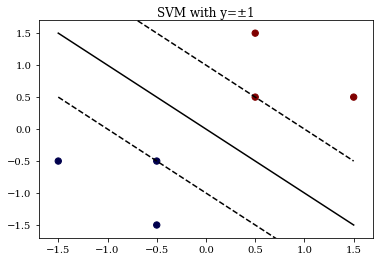

In [700]:
# Plot SVM
q1,q2,b = q
# b = cvx_b.value
plt.scatter(X[:,0],X[:,1],c=y,s=40*np.abs(y),cmap='seismic');
s = np.linspace(min(x1),max(x1),10)
plt.plot(s,1/q2*(-b-q1*s),'k')
plt.plot(s,1/q2*(-1-b-q1*s),'k--')
plt.plot(s,1/q2*(1-b-q1*s),'k--')
plt.axis(xmin=-1.7,xmax=1.7,ymax=1.7,ymin=-1.7)
plt.title('SVM with y=±1');

In [702]:
# Solve primal
r = np.array([-1,-2,-1,1,2,1])
n = len(r)
risk_neutral = lambda x: x
exp_utility = lambda x: -cvx.exp(-5*x)
u = exp_utility
q = cvx.Variable(3)
objective = cvx.Maximize(
    1/(1*n)*cvx.sum_entries(u(cvx.mul_elemwise(r,X*q+cvx_b))) -
    1*(cvx.norm(q)**2+cvx_b**2))
prob = cvx.Problem(objective)
prob.solve()
q = q.value.A1

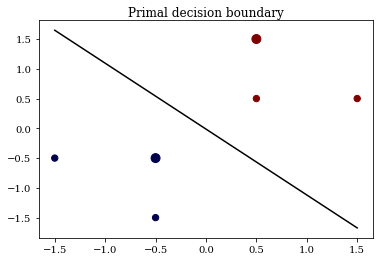

In [703]:
# Plot primal
q1,q2,b = q
# b = cvx_b.value
plt.scatter(X[:,0],X[:,1],c=np.where(r>0,1,-1),s=40*np.abs(r),cmap='seismic')
s = np.linspace(min(x1),max(x1),10)
plt.plot(s,1/q2*(-b-q1*s),'k');
# plt.plot(s,1/q2*(0.5-b-q1*s),'k--');
# plt.plot(s,1/q2*(-0.5-b-q1*s),'k--');
plt.title('Primal decision boundary');

In [5]:
r = np.array([-1,-2,-1,1,2,2,-2])
x1 = np.array([-1.5,-0.5,-0.5,0.5,0.5,1.5,0])
x2 = np.array([-0.5,-0.5,-1.5,0.5,1.5,0.5,2])
X = np.array([x1,x2]).T
X = np.column_stack((X,np.ones(len(r))))

In [6]:
# ker = lambda x,y: (np.inner(x,y) + 1)**3
# ker = lambda x,y: np.tanh(0.01*np.inner(x,y))
# ker = lambda x,y: np.exp(-np.inner(x-y,x-y))
# ker = lambda x,y: np.exp(np.inner(x,y))

In [7]:
# K = np.exp(-squareform(pdist(X))**2/25)

In [56]:
def quad_K(X1,X2=None):
    if X2 is None:
        X2 = X1
    K = (np.inner(X1,X2)+1)**3
    return K

sigma = 1
def gauss_K(X1,X2=None):
    if X2 is None:
        K = np.exp(-squareform(pdist(X1))**2/sigma)
        return K
    else:
        K = np.exp(-cdist(X1,X2)**2/sigma).T
        return K

In [57]:
# Solve dual
# K = quad_K(X)
K = gauss_K(X)
a = cvx.Variable(len(r))
ra = cvx.mul_elemwise(r,a)
objective = -cvx.sum_entries(cvx.kl_div(a,1)) - 0.1*cvx.quad_form(ra,K)
prob = cvx.Problem(cvx.Maximize(objective))
prob.solve()
a = a.value.A1

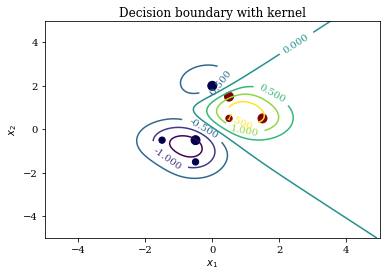

In [59]:
delta = 500
xx1 = np.linspace(-5,5,delta)
xx2 = np.linspace(-5,5,delta)
X_s = np.array(np.meshgrid(xx1,xx2,[1])).T[0].reshape((delta*delta,3))
phi = gauss_K(X,X_s)
Z = np.inner(phi,a*r).reshape((delta,delta)).T
plt.scatter(X[:,0],X[:,1],c=np.where(r>0,1,-1),s=40*np.abs(r),cmap='seismic');
cont = plt.contour(xx1,xx2,Z)
plt.clabel(cont)
plt.title('Decision boundary with kernel');
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');